# Red neuronal con diferentes funciones de activacion y propagación de errores hacia atrás (backpropagation)

## 1. Diagrama general del aprendizajo supervisado en ML

![title](https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/aprendizajesupervizado.png)

### Tipos de funciones de activación:
Fuente: https://mlfromscratch.com/activation-functions-explained/#/
![title](https://mlfromscratch.com/content/images/2019/12/activation-functions.gif)

Tómese en cuenta lo siguiente.

- Los bias y pesos son inicialmente aleatorios, pero de alguna manera se deben ajustar mediante iteraciones.
- Cada conexión tiene un peso.
- Cada neurona tiene un bias. 

### Error (métrica)
- Se requiere una métrica que mida qué tan cerca o lejos del valor esperado son las predicciones de la red (función de costo o de pérdida).
- Es necesario un algoritmo que minimize la función anterior.
- Si no se emplea una función de activación no lineal, la suma ponderada y toda la estructura de la red solamente proveerán transformaciones lineales.


Consíderese lo siguiente:


- Función de costo: 
$C(w, b) ≡ \frac{1}{2} \Sigma_x || y(x) − a(x,w,b)||^2$, donde a es la predicción de la RNA.
- Métodos analíticos de minimización no son útiles para muchas variables.
- Se requiere un algoritmo para minimizar la función de costo: descenso del gradiente.
- El descenso del gradiente únicamente calcula gradientes, es el más simple de toda una familia de algoritmos de minimización.

### Descenso del gradiente (intuición)

- La deducción no es propósito de esta notebook, pero cada nuevo paso en busca de la minimización de la función de costo, obedece la siguiente regla:

$ v -> v' = v - \eta \nabla C$, donde $v$ es $f(w, b)$ y $\eta$ la tasa de aprendizaje (tamaño de paso, learning rate)

- Se da un paso en dirección opuesta al gradiente hasta minimizar la función de costo.

- Se le llama *backpropagation* al algoritmo que realiza esto iterativamente desde la última capa hasta la primera.

Fuente: https://kevinbinz.com/2019/05/26/intro-gradient-descent/

![title](https://kevinbinz.files.wordpress.com/2019/05/dualspace_explore.gif)

- Se quiere encontrar (x,y) tal que sea un mínimo en la superficie (función de costo).

Fuente: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

![title](https://miro.medium.com/max/819/1*hUd744hDEEGx0-ypWGhrkw.gif)


In [88]:
import numpy as np
import matplotlib.pyplot as plt

In [89]:
class NeuralNet:
    def __init__(self, X, Y, nodos, p_split, learning_rate, epocas, fn_activation='relu'):
        self.X = X
        self.Y = Y
        self.nodos = nodos
        self.p_split = p_split
        self.learning_rate = learning_rate
        self.epocas = epocas
        
        if fn_activation == 'relu':
            self.activation = self.relu
            self.dactivation = self.drelu
        elif fn_activation == 'sigmoide':
            self.activation = self.sigmoid
            self.dactivation = self.dsigmoid
        elif fn_activation == 'tanh':
            self.activation = self.tanh
            self.dactivation = self.dtanh
        elif fn_activation == 'identidad':
            self.activation = self.iden
            self.dactivation = self.diden  

    def relu(self, x):
        return x * (x > 0)

    def drelu(self, x):
        return 1. * (x > 0)

    #IDENTIDAD
    def iden(self, X):
        return X

    def diden(self, X):
        return 1

    #SIGMOIDE
    def sigmoid(self, X):
        return 1/(1.0+np.exp(-X))

    def dsigmoid(self, X):
        return self.sigmoid(X)*(1-self.sigmoid(X))

    def tanh(self, X):
        return np.tanh(X)
    
    def dtanh(self, X):
        return 1-self.tanh(X)**2
    # Definimos la estructura de la red
    
    def error(self, vector):
        m = len(vector)
        mse = (1/(2*m))*np.linalg.norm(vector)**2
        return mse
    
    def split(self, X, Y, p_split): #El p_split debe estar dado entre 0 y 1
        nparams = len(X)
        randomize = np.random.permutation(nparams)
        X = X[randomize]
        Y = Y[randomize]
        ntrain = int(p_split * nparams)
        indx = [ntrain]
        X_train, X_test = np.split(X, indx)
        Y_train, Y_test = np.split(Y, indx)
    
        return X_train, Y_train, X_test, Y_test
    
    def entrenar(self):
        n_entradas=len(self.X[0])
        n_salidas=len(self.Y[0])

        #definimos los conjuntos de aprendizaje y validación 
        X_learn,Y_learn,X_val,Y_val = self.split(self.X, self.Y, self.p_split)

        #forward
        W1 = np.random.randn(n_entradas,self.nodos)
        W2 = np.random.randn(self.nodos, n_salidas)
        b1 = np.random.randn(self.nodos)
        b2 = np.random.randn(n_salidas)

        #épocas
        self.errores=[]
        self.validacion=[]
        for i in range(self.epocas):
            #Forward
            z1=np.dot(X_learn,W1)+b1
            a1=self.activation(z1)
            z2=np.dot(a1,W2)+b2
            a2=z2

            #backpropagation
            delta2 = a2 - Y_learn
            delta1 = (delta2).dot(W2.T)*self.dactivation(z1)

            self.errores.append(self.error(delta2)) #guardamos el error de cada época

            W2 -= self.learning_rate * a1.T.dot(delta2)
            b2 -= self.learning_rate * (delta2).sum(axis=0)

            W1 -= self.learning_rate * X_learn.T.dot(delta1)
            b1 -= self.learning_rate * (delta1).sum(axis=0)

            print("Época: %d, Error: %f" %(i+1, self.error(delta2)))

            #Ahora validamos el modelo
            z1 = np.dot(X_val, W1) + b1
            a1 = self.activation(z1)
            z2 = np.dot(a1,W2)+b2
            a2 = z2
            delta = a2-Y_val
            self.validacion.append(self.error(delta))
        
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2   

    def plot(self):
#         for i in range(self.epocas):
        plt.plot(range(self.epocas),self.errores,color='darkcyan',label='Aprendizaje')
        plt.plot(range(self.epocas),self.validacion,color='darkred',label='Validación')
        plt.grid()
        plt.legend()
     

    def evaluar(self, x):
        z1=np.dot(x,self.W1)+self.b1
        a1=self.activation(z1)
        z2=np.dot(a1,self.W2)+self.b2
        a2=z2
        return a2

In [80]:
def Hlcdm(z, Om=0.27, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)


X=2.3*np.random.rand(1000,1)
Y=Hlcdm(X, Om=0.27, H0=73.24)

In [81]:
neuralnet = NeuralNet(X,Y,10,0.2,0.0001,1000,fn_activation='sigmoide')
neuralnet.entrenar()

Época: 1, Error: 9713.838953
Época: 2, Error: 7539.256907
Época: 3, Error: 5432.452496
Época: 4, Error: 3903.909510
Época: 5, Error: 2885.774282
Época: 6, Error: 2223.614326
Época: 7, Error: 1794.233299
Época: 8, Error: 1513.651377
Época: 9, Error: 1326.388435
Época: 10, Error: 1195.641600
Época: 11, Error: 1096.315315
Época: 12, Error: 1010.657096
Época: 13, Error: 926.802252
Época: 14, Error: 840.606160
Época: 15, Error: 756.438722
Época: 16, Error: 680.155734
Época: 17, Error: 612.766926
Época: 18, Error: 553.102322
Época: 19, Error: 500.379937
Época: 20, Error: 453.929630
Época: 21, Error: 413.066180
Época: 22, Error: 377.121996
Época: 23, Error: 345.471081
Época: 24, Error: 317.542422
Época: 25, Error: 292.827272
Época: 26, Error: 270.881065
Época: 27, Error: 251.320821
Época: 28, Error: 233.819710
Época: 29, Error: 218.100353
Época: 30, Error: 203.927980
Época: 31, Error: 191.104006
Época: 32, Error: 179.460299
Época: 33, Error: 168.854210
Época: 34, Error: 159.164337
Época: 35, 

Época: 795, Error: 0.982926
Época: 796, Error: 0.972979
Época: 797, Error: 0.978734
Época: 798, Error: 0.968853
Época: 799, Error: 0.974574
Época: 800, Error: 0.964759
Época: 801, Error: 0.970445
Época: 802, Error: 0.960695
Época: 803, Error: 0.966348
Época: 804, Error: 0.956662
Época: 805, Error: 0.962282
Época: 806, Error: 0.952660
Época: 807, Error: 0.958246
Época: 808, Error: 0.948687
Época: 809, Error: 0.954241
Época: 810, Error: 0.944745
Época: 811, Error: 0.950267
Época: 812, Error: 0.940832
Época: 813, Error: 0.946322
Época: 814, Error: 0.936948
Época: 815, Error: 0.942407
Época: 816, Error: 0.933094
Época: 817, Error: 0.938521
Época: 818, Error: 0.929269
Época: 819, Error: 0.934665
Época: 820, Error: 0.925472
Época: 821, Error: 0.930838
Época: 822, Error: 0.921703
Época: 823, Error: 0.927039
Época: 824, Error: 0.917963
Época: 825, Error: 0.923269
Época: 826, Error: 0.914251
Época: 827, Error: 0.919528
Época: 828, Error: 0.910566
Época: 829, Error: 0.915814
Época: 830, Error: 0

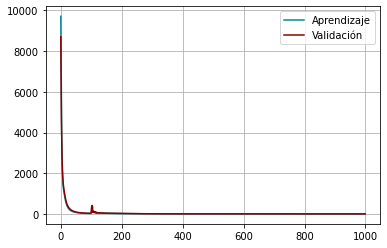

In [82]:
neuralnet.plot()

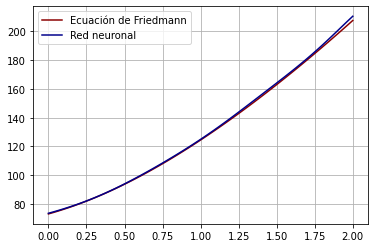

In [86]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkred',label='Ecuación de Friedmann')
plt.plot(z, neuralnet.evaluar(z),label='Red neuronal',color='darkblue')
# plt.plot(X1,Y1,'.', label='Datos reales')
plt.legend()
plt.grid()